In [219]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
fish-gcp005
/home/akarshkumar0101/nca-alife
/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/bin/python


In [220]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [221]:
# import experiment_utils
import time
import subprocess

# Launch Experiment (on this node)

In [248]:
header = '\n'.join([
    '#!/bin/bash',
    
    # 'source ~/.virtualenvs/nca-alife-torch/bin/activate'
    
    'source ~/miniconda3/etc/profile.d/conda.sh',
    'conda activate nca-alife-jax',
    
    'cd ~/nca-alife/src'
])


gpus = [4, 5, 6, 7]
log_dir = os.path.expanduser(f'~/nca-alife-data/logs/{time.strftime("%Y_%m_%d_%H_%M_%S")}')
exp_sh = f'./src/experiments/main.sh'
with open(exp_sh, 'r') as f:
    commands = [c for c in f.read().split('\n') if c]
print(f"{exp_sh} has {len(commands)} commands: ")
print('\n'.join(commands[:3]), '\n...')
print(f"Logging to {log_dir}")

./src/experiments/main.sh has 40 commands: 
python train_target_emergence_plife.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/plife_cma/0_alpha_0"                  --n_particles=5000 --n_colors=6 --search_space="alpha"                  --render_radius=0.007 --rollout_steps=1024 --n_rollout_imgs=8 --algo="Sep_CMA_ES" --bs=1 --pop_size=8 --n_iters=1000 --sigma=1.0 --prompt="a biological cell"                             
python train_target_emergence_plife.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/plife_cma/0_alpha_1"                  --n_particles=5000 --n_colors=6 --search_space="alpha"                  --render_radius=0.007 --rollout_steps=1024 --n_rollout_imgs=8 --algo="Sep_CMA_ES" --bs=1 --pop_size=8 --n_iters=1000 --sigma=1.0 --prompt="a biological cell under the microscope"        
python train_target_emergence_plife.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/plife_cma/0_alpha_2"                  --n_particles=5000 --n_colors=6 -

In [249]:
print(log_dir)

/home/akarshkumar0101/nca-alife-data/logs/2024_08_14_14_04_28


In [250]:
!mkdir -p {log_dir}
!rm {os.path.dirname(log_dir)+'/latest'}
!ln -sf {log_dir} {os.path.dirname(log_dir)+'/latest'}
for i_gpu, gpu in enumerate(gpus):
    job_ids = np.arange(len(commands))[i_gpu::len(gpus)]
    cvd = f'export CUDA_VISIBLE_DEVICES={gpu}'
    txt = f"{header}\n{cvd}\n\n"
    for job_id in job_ids:
        txt += f"touch {log_dir}/job_{job_id:05d}.status\n"
        txt += f"{commands[job_id]} &> {log_dir}/job_{job_id:05d}.out\n"
        txt += f"echo $? > {log_dir}/job_{job_id:05d}.status\n\n"
    with open(f"{log_dir}/gpu_{gpu}.sh", "w") as f:
        f.write(txt)

In [251]:
print('\n'.join(txt.split('\n')[:24]))

#!/bin/bash
source ~/miniconda3/etc/profile.d/conda.sh
conda activate nca-alife-jax
cd ~/nca-alife/src
export CUDA_VISIBLE_DEVICES=7

touch /home/akarshkumar0101/nca-alife-data/logs/2024_08_14_14_04_28/job_00003.status
python train_target_emergence_plife.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/plife_cma/0_alpha_3"                  --n_particles=5000 --n_colors=6 --search_space="alpha"                  --render_radius=0.007 --rollout_steps=1024 --n_rollout_imgs=8 --algo="Sep_CMA_ES" --bs=1 --pop_size=8 --n_iters=1000 --sigma=1.0 --prompt="bacteria under the microscope"                  &> /home/akarshkumar0101/nca-alife-data/logs/2024_08_14_14_04_28/job_00003.out
echo $? > /home/akarshkumar0101/nca-alife-data/logs/2024_08_14_14_04_28/job_00003.status

touch /home/akarshkumar0101/nca-alife-data/logs/2024_08_14_14_04_28/job_00007.status
python train_target_emergence_plife.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/plife_cma/0_alpha_7"                

In [252]:
for i_gpu, gpu in enumerate(gpus):
    command = f"bash {log_dir}/gpu_{gpu}.sh"
    print(command)
    process = subprocess.Popen(command, shell=True)

bash /home/akarshkumar0101/nca-alife-data/logs/2024_08_14_14_04_28/gpu_4.sh
bash /home/akarshkumar0101/nca-alife-data/logs/2024_08_14_14_04_28/gpu_5.sh
bash /home/akarshkumar0101/nca-alife-data/logs/2024_08_14_14_04_28/gpu_6.sh
bash /home/akarshkumar0101/nca-alife-data/logs/2024_08_14_14_04_28/gpu_7.sh


# Track Experiment

In [22]:
import subprocess
a = subprocess.run(['ps', 'ux'], stdout=subprocess.PIPE).stdout.decode('utf-8')

In [25]:
[l for l in a.split('\n') if "bash" in l and "gpu" in l]

['akarshk+ 1271851  0.0  0.0   2480   572 ?        S    04:58   0:00 /bin/sh -c bash /home/akarshkumar0101/nca-alife-data/logs/2024_07_31_04_58_39/gpu_4.sh',
 'akarshk+ 1271852  0.0  0.0   2480   516 ?        S    04:58   0:00 /bin/sh -c bash /home/akarshkumar0101/nca-alife-data/logs/2024_07_31_04_58_39/gpu_5.sh',
 'akarshk+ 1271853  0.0  0.0 219972  3408 ?        S    04:58   0:00 bash /home/akarshkumar0101/nca-alife-data/logs/2024_07_31_04_58_39/gpu_4.sh',
 'akarshk+ 1271854  0.0  0.0   2480   512 ?        S    04:58   0:00 /bin/sh -c bash /home/akarshkumar0101/nca-alife-data/logs/2024_07_31_04_58_39/gpu_6.sh',
 'akarshk+ 1271855  0.0  0.0 219972  3200 ?        S    04:58   0:00 bash /home/akarshkumar0101/nca-alife-data/logs/2024_07_31_04_58_39/gpu_5.sh',
 'akarshk+ 1271856  0.0  0.0   2480   516 ?        S    04:58   0:00 /bin/sh -c bash /home/akarshkumar0101/nca-alife-data/logs/2024_07_31_04_58_39/gpu_7.sh',
 'akarshk+ 1271857  0.0  0.0 219972  3460 ?        S    04:58   0:00 bash 

Terminated
Terminated
Terminated
Terminated


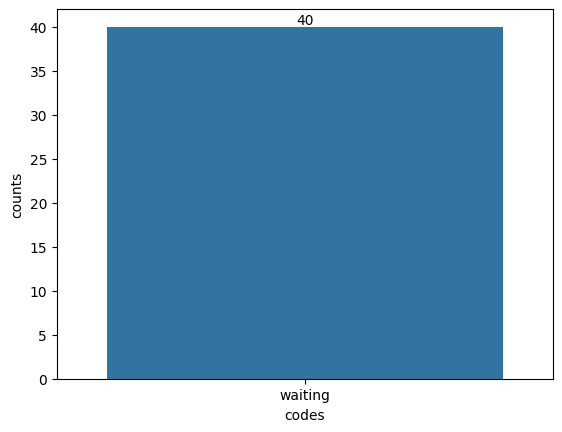

In [253]:
from collections import defaultdict

status = []
for job_id in range(len(commands)):
    try:
        with open(f"{log_dir}/job_{job_id:05d}.status", "r") as f:
            status.append(int(f.read().strip()))
    except Exception as e:
        status.append("waiting")
status = np.array(status)

codes, counts = np.unique(status, return_counts=True)
df = pd.DataFrame(dict(codes=codes, counts=counts))
ax = sns.barplot(data=df, x='codes', y='counts')
ax.bar_label(ax.containers[0], fontsize=10);

In [299]:
for job_id in list(range(len(commands))):
    print()
    print(f'------------------------------------------------------ {job_id} ------------------------------------------------------')
    print()
    try:
        with open(f"{log_dir}/job_{job_id:05d}.out", "r") as f:
            print(f.readlines()[-1].strip())
    except Exception as e:
        # pass
        break
        print(e)


------------------------------------------------------ 0 ------------------------------------------------------

23%|██▎       | 228/1000 [07:40<20:38,  1.60s/it, best_loss=-0.316]

------------------------------------------------------ 1 ------------------------------------------------------

22%|██▏       | 216/1000 [07:41<22:21,  1.71s/it, best_loss=-0.306]

------------------------------------------------------ 2 ------------------------------------------------------

21%|██▏       | 214/1000 [07:41<23:04,  1.76s/it, best_loss=-0.312]

------------------------------------------------------ 3 ------------------------------------------------------

23%|██▎       | 226/1000 [07:41<21:18,  1.65s/it, best_loss=-0.314]

------------------------------------------------------ 4 ------------------------------------------------------



In [298]:
log_dir

'/home/akarshkumar0101/nca-alife-data/logs/2024_08_14_14_04_28'